In [1]:
import math
import os
import cv2
import sys
import argparse
from pathlib import Path
from typing import Iterable
from PIL import Image
import numpy as np
import random
import torch
from torch.utils.data import DataLoader, DistributedSampler, SubsetRandomSampler
from util import box_ops
import util.misc as utils
import datasets
from datasets.coco import make_coco_transforms
import torchvision.transforms as T

import datasets.samplers as samplers
from datasets import build_dataset, get_coco_api_from_dataset
from engine_test import evaluate, train_one_epoch
from models import build_model
from models import laprop

import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

/home/ayina/anaconda3/envs/cottonweed3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cats = [
    "N/A",
    "Waterhemp",
    "MorningGlory",
    "Purslane",
    "SpottedSpurge",
    "Carpetweed",
    "Ragweed",
    "Eclipta",
    "PricklySida",
    "PalmerAmaranth",
    "Sicklepod",
    "Goosegrass",
    "CutleafGroundcherry"
]

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h,
                          img_w, img_h
                          ], dtype=torch.float32)
    return b

In [3]:
def generate_mask(image_size, grid_size, prob_thresh):
    image_w, image_h = image_size
    grid_w, grid_h = grid_size
    cell_w, cell_h = math.ceil(image_w / grid_w), math.ceil(image_h / grid_h)
    up_w, up_h = (grid_w + 1) * cell_w, (grid_h + 1) * cell_h

    mask = (np.random.uniform(0, 1, size=(grid_h, grid_w)) <
            prob_thresh).astype(np.float32)
    mask = cv2.resize(mask, (up_w, up_h), interpolation=cv2.INTER_LINEAR)
    offset_w = np.random.randint(0, cell_w)
    offset_h = np.random.randint(0, cell_h)
    mask = mask[offset_h:offset_h + image_h, offset_w:offset_w + image_w]
    return mask

def mask_image(image, mask):
    masked = ((image.astype(np.float32) / 255 * np.dstack([mask] * 3)) * 255).astype(np.uint8)
    return masked

def iou(box1, box2):
    box1 = np.asarray(box1)
    box2 = np.asarray(box2)
    tl = np.vstack([box1[:2], box2[:2]]).max(axis=0)
    br = np.vstack([box1[2:], box2[2:]]).min(axis=0)
    intersection = np.prod(br - tl) * np.all(tl < br).astype(float)
    area1 = np.prod(box1[2:] - box1[:2])
    area2 = np.prod(box2[2:] - box2[:2])
    return intersection / (area1 + area2 - intersection)

In [19]:
# @torch.no_grad()
# def evaluate(model, criterion, postprocessors, data_loader, base_ds, device, thres=0.8, cats=cats):
#     model.eval()
#     criterion.eval()

#     for samples, targets in data_loader:

#         targets = [{k: v for k, v in t.items()} for t in targets]
#         target = targets[0]
#         target_classes = target['labels'].numpy().astype('int')
#         orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0)
#         img_h, img_w = orig_target_sizes.unbind(1)
        
#         tboxes = box_ops.box_cxcywh_to_xyxy(target["boxes"])
#         scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
#         tboxes = tboxes * scale_fct[:, None, :]
#         tboxes = tboxes[0].numpy().astype(int)
        
#         # set parameters for saliency map creation
        
#         target_class_index = 4
        
#         #print("target box")
#         for j, box in enumerate(tboxes):
#             cat_id = int(target_classes[j])
#             #print(cat_id, box)
#             if cat_id == target_class_index:
#                 target_box = box
        
#         target_box = target_box.astype(int)
#         prob_thresh= 0.6
#         grid_size= (16, 16)
#         n_masks= 10
        
#         print("target_box ", target_box)
        
#         # original image for plotting later
        
#         image_id = target["image_id"].numpy().astype('int')[0]
#         file_name = f"{image_id:012d}.jpg"
#         src_path = "/home/ayina/MscThesis/DCW/datasets/Dataset_final/DATA_0_COCO_format/test2017/"
#         img_path = src_path + file_name
        
#         orig_image_pl = Image.open(img_path)
#         print("image")
#         print(np.asarray(orig_image_pl))
#         w, h = orig_image_pl.size
#         transform = make_coco_transforms("test")
#         dummy_target = {
#             "size": torch.as_tensor([int(h), int(w)]),
#             "orig_size": torch.as_tensor([int(h), int(w)])
#         }
#         image, targets = transform(orig_image_pl, dummy_target)
#         print("transformed image")
#         print(image)
#         image = image.unsqueeze(0)
#         image = image.to(device)
#         outputs = model(image)
        
#         outputs["pred_logits"] = outputs["pred_logits"].cpu()
#         outputs["pred_boxes"] = outputs["pred_boxes"].cpu()
        
#         probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
#         # keep = probas.max(-1).values > 0.85
#         keep = probas.max(-1).values > prob_thresh

#         bboxes_scaled = rescale_bboxes(
#             outputs['pred_boxes'][0, keep], orig_image_pl.size)
#         probas = probas[keep].cpu().data.numpy()
        
#         for p, box in zip(probas, bboxes_scaled):
#             print(p)
#             cat_id = p.argmax()
#             cat = cats[cat_id]
#             score = p[cat_id]
#             bbox = box.cpu().data.numpy().astype(np.int32)
#             print("results: ", cat_id, score, bbox)
        
        # fig = plt.figure(figsize=(8, 6))
        # fig.add_subplot()
        # img = np.array(orig_image_pl)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    
            

                # if (cat_id == target_class_index):
                #     result = iou(target_box, bbox)
                #     iou_score = max([result * score], default=0)

#         res += mask * iou_score
            
#         ax = plt.gca()
#         ax.imshow(img)         
#         #ax.imshow(image.astype('uint8'))
#         ax.add_patch(plt.Rectangle((target_box[0], target_box[1]), target_box[2] - target_box[0], 
#                                    target_box[3] - target_box[1], fill=False, color='white', linewidth=3))
#         ax.imshow(res, cmap='jet_r', alpha=0.5)
#         ax.set_title('Prediction Saliency Map', fontsize=8)

#     plt.axis('off')
#     plt.show()

    return

In [6]:
@torch.no_grad()
def evaluate(model, criterion, postprocessors, data_loader, base_ds, device, cats=cats):
    model.eval()
    criterion.eval()

    for samples, targets in data_loader:

        targets = [{k: v for k, v in t.items()} for t in targets]
        target = targets[0]
        target_classes = target['labels'].numpy().astype('int')
        orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0)
        img_h, img_w = orig_target_sizes.unbind(1)
        img_hh = img_h[0].numpy()
        img_ww = img_w[0].numpy()
        
        tboxes = box_ops.box_cxcywh_to_xyxy(target["boxes"])
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        tboxes = tboxes * scale_fct[:, None, :]
        tboxes = tboxes[0].numpy().astype(int)
        
        # set parameters for saliency map creation
        
        target_class_index = 5
        misclass = 5
        
        for j, box in enumerate(tboxes):
            cat_id = int(target_classes[j])
            if cat_id == target_class_index:
                target_box = box
        
        target_box = target_box.astype(int)
        prob_thresh= 0.25
        grid_size= (16, 16)
        n_masks= 1250
        
        res = np.zeros((img_hh, img_ww), dtype=np.float32)
        
        print("target_box ", target_box)
        
        #########################################
        
        # original image for plotting later
        
        image_id = target["image_id"].numpy().astype('int')[0]
        file_name = f"{image_id:012d}.jpg"
        src_path = "/home/ayina/MscThesis/DCW/datasets/Dataset_final/DATA_0_COCO_format/test2017/"
        img_path = src_path + file_name
        print("image_id: ", image_id)
        
        orig_image_pl = Image.open(img_path)
        # w, h = orig_image_pl.size
        
        orig_image = cv2.imread(img_path)
        h, w = orig_image.shape[:2]
        
        #generate masks
        
        for _ in range(n_masks):
            mask = generate_mask(image_size=(w, h),
                                 grid_size=grid_size,
                                 prob_thresh=prob_thresh)
            masked = mask_image(orig_image, mask)
            masked = cv2.cvtColor(masked, cv2.COLOR_BGR2RGB)
            masked = Image.fromarray(masked)
        
            transform = make_coco_transforms("test")
            dummy_target = {
                "size": torch.as_tensor([int(h), int(w)]),
                "orig_size": torch.as_tensor([int(h), int(w)])
            }  

            image, targets = transform(masked, dummy_target)
            image = image.unsqueeze(0)
            image = image.to(device)
        
            # Run model
            with torch.no_grad():
                outputs = model(image)
        
            outputs["pred_logits"] = outputs["pred_logits"].cpu()
            outputs["pred_boxes"] = outputs["pred_boxes"].cpu()     
            
            probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
            keep = probas.max(-1).values > prob_thresh

            bboxes_scaled = rescale_bboxes(
                outputs['pred_boxes'][0, keep], orig_image_pl.size)
            probas = probas[keep].cpu().data.numpy()
            
            max_iou_score = 0
            
            for p, box in zip(probas, bboxes_scaled):
                cat_id = p.argmax()
                cat = cats[cat_id]
                score = p[cat_id]
                bbox = box.cpu().data.numpy().astype(np.int32)
                #print("results: ", cat_id, cat, score, bbox)
                if (cat_id == target_class_index):
                    iou_score = iou(target_box, bbox) * score
                    if iou_score > max_iou_score:
                        max_iou_score = iou_score       

            res += mask * max_iou_score
        
        fig = plt.figure(figsize=(6, 4))
        fig.add_subplot()
        
        img = np.array(orig_image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = plt.gca()
        ax.imshow(img)         
        ax.add_patch(plt.Rectangle((target_box[0], target_box[1]), target_box[2] - target_box[0], 
                                   target_box[3] - target_box[1], fill=False, color='white', linewidth=3))
        ax.imshow(res, cmap='jet', alpha=0.4)
        ax.set_title('Prediction Saliency Map', fontsize=8)

    plt.axis('off')
    plt.show()

    plt.show()    
    return

Not using distributed mode
Building final layer with classes :  13
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Keeping all the original weights.
target_box  [1416  966 1781 1332]


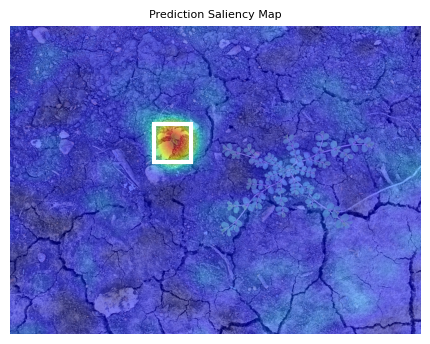

In [44]:
#image 23

#target class = 12
#misclassification = 8
main(args)

Not using distributed mode
Building final layer with classes :  13
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Keeping all the original weights.
target_box  [1108  838 2216 2412]
image_id:  6


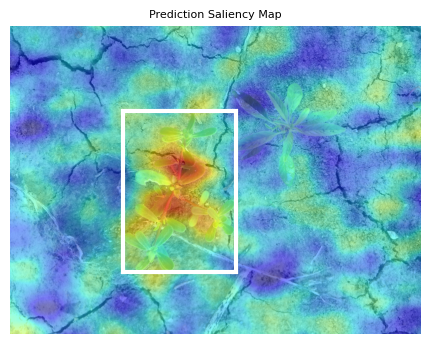

In [18]:
#image 3
#target class 3
main(args)

Not using distributed mode
Building final layer with classes :  13
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Keeping all the original weights.
target_box  [ 761   13 3851 2330]
image_id:  162


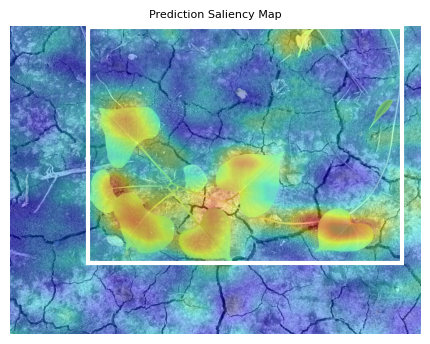

In [30]:
#image 162
#target class: 2 (morning glory)

main(args)

Not using distributed mode
Building final layer with classes :  13
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Keeping all the original weights.
target_box  [   2  422 3884 2413]
image_id:  807


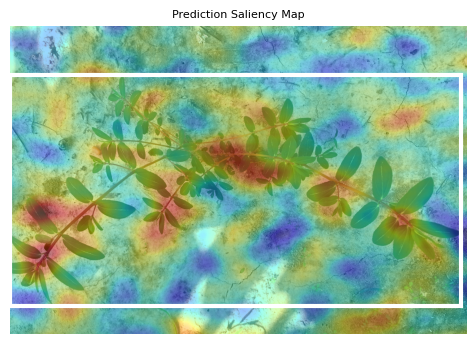

In [39]:
#image 807
#target class: 4

main(args)

Not using distributed mode
Building final layer with classes :  13
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
Keeping all the original weights.
target_box  [1199  386 1902 1840]
image_id:  356


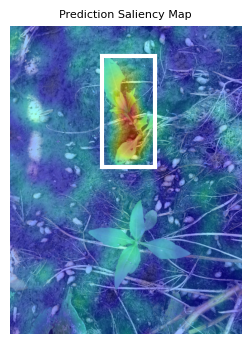

In [51]:
#image 356
#target class 7
main(args)

Not using distributed mode
Building final layer with classes :  13
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Keeping all the original weights.
target_box  [ 347  714 2661 2934]
image_id:  600


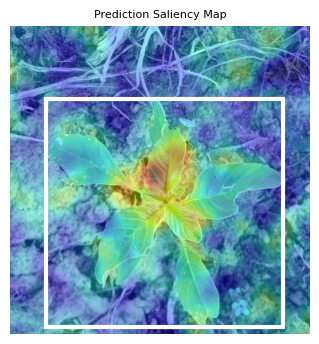

In [12]:
#image 600
#target class: 1 (waterhemp)

main(args)

In [9]:
#image 681
#target class: 5 (carpetweed)

main(args)

Not using distributed mode
Building final layer with classes :  13
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


FileNotFoundError: [Errno 2] No such file or directory: './runs_scratch_lr2/checkpoint.pth'

In [8]:
def main(args):
    
    args.eval = True
    args.no_aux_loss = True
    args.with_box_refine = True
    args.two_stage = True
    
    utils.init_distributed_mode(args)

    device = torch.device(args.device)

    # fix the seed for reproducibility
    seed = args.seed + utils.get_rank()
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model, criterion, postprocessors = build_model(args)
    model.to(device)

    model_without_ddp = model
    n_parameters = sum(p.numel()
                       for p in model.parameters() if p.requires_grad)

    dataset_train = build_dataset(image_set='train', args=args)
    dataset_val = build_dataset(image_set='val', args=args)
    dataset_test = build_dataset(image_set='test', args=args)

    if args.distributed:
        if args.cache_mode:
            sampler_train = samplers.NodeDistributedSampler(dataset_train)
            sampler_val = samplers.NodeDistributedSampler(
                dataset_val, shuffle=False)
        else:
            sampler_train = samplers.DistributedSampler(dataset_train)
            sampler_val = samplers.DistributedSampler(
                dataset_val, shuffle=False)
    else:
        sampler_train = torch.utils.data.RandomSampler(dataset_train)
        sampler_val = torch.utils.data.SequentialSampler(dataset_val)
        sampler_test = torch.utils.data.SequentialSampler(dataset_test)

    batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, args.batch_size, drop_last=True)

    data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                   collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                   pin_memory=True)
    data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                                 drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers,
                                 pin_memory=True)
    # data_loader_test = DataLoader(dataset_test, args.batch_size, sampler= samplers.SubsetRandomSampler(22),
    #                               drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)
    
    index = int(args.task)-1
    indices = [index]
    subset = torch.utils.data.Subset(dataset_test, indices)

    data_loader_test = DataLoader(subset, args.batch_size, sampler=torch.utils.data.SequentialSampler(subset),
                                  drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

    def match_name_keywords(n, name_keywords):
        out = False
        for b in name_keywords:
            if b in n:
                out = True
                break
        return out

    param_dicts = [
        {
            "params":
                [p for n, p in model_without_ddp.named_parameters()
                 if not match_name_keywords(n, args.lr_backbone_names) and not match_name_keywords(n, args.lr_linear_proj_names) and p.requires_grad],
            "lr": args.lr,
        },
        {
            "params": [p for n, p in model_without_ddp.named_parameters() if match_name_keywords(n, args.lr_backbone_names) and p.requires_grad],
            "lr": args.lr_backbone,
        },
        {
            "params": [p for n, p in model_without_ddp.named_parameters() if match_name_keywords(n, args.lr_linear_proj_names) and p.requires_grad],
            "lr": args.lr * args.lr_linear_proj_mult,
        }
    ]
    if args.sgd:
        optimizer = torch.optim.SGD(param_dicts, lr=args.lr, momentum=0.9,
                                    weight_decay=args.weight_decay)
    elif args.laprop:
        optimizer = laprop.LaProp(param_dicts, lr=args.lr,
                                  weight_decay=args.weight_decay)
    else:
        optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,
                                      weight_decay=args.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)

    if args.distributed:
        model = torch.nn.parallel.DistributedDataParallel(
            model, device_ids=[args.gpu])
        model_without_ddp = model.module

    if args.dataset_file == "coco_panoptic":
        # We also evaluate AP during panoptic training, on original coco DS
        coco_val = datasets.coco.build("val", args)
        base_ds = get_coco_api_from_dataset(coco_val)
    else:
        base_ds = get_coco_api_from_dataset(dataset_test)

    if args.frozen_weights is not None:
        checkpoint = torch.load(args.frozen_weights, map_location='cpu')
        model_without_ddp.detr.load_state_dict(checkpoint['model'])

    if args.resume:
        if args.resume.startswith('https'):
            checkpoint = torch.hub.load_state_dict_from_url(
                args.resume, map_location='cpu', check_hash=True)
        else:
            # LOAD WEIGHTS INTO MODEL
            checkpoint = torch.load(args.resume, map_location='cpu')
            # When number of classes changes, modify the model as well. Otherwise, keep original weights !
            if args.num_classes != 13 or args.dataset_file != 'coco':
                print(
                    f"Deleting last linear layer weights as num_classes is different {args.num_classes} than expected for coco (91)")
                keys = list(checkpoint['model'].keys())
                for i in keys:
                    if 'class_embed' in i:
                        del checkpoint["model"][i]
            else:
                print("Keeping all the original weights.")
        missing_keys, unexpected_keys = model_without_ddp.load_state_dict(
            checkpoint['model'], strict=False)
        unexpected_keys = [k for k in unexpected_keys if not (
            k.endswith('total_params') or k.endswith('total_ops'))]
        if not args.eval and 'optimizer' in checkpoint and 'lr_scheduler' in checkpoint and 'epoch' in checkpoint:
            import copy

            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
            if args.override_resumed_lr_drop:
                lr_scheduler.step_size = args.lr_drop
                lr_scheduler.base_lrs = list(
                    map(lambda group: group['initial_lr'], optimizer.param_groups))
            lr_scheduler.step(lr_scheduler.last_epoch)
            args.start_epoch = checkpoint['epoch'] + 1
        # check the resumed model
        if not args.eval:
            test_stats, coco_evaluator, val_loss = evaluate(
                model, criterion, postprocessors, data_loader_test, base_ds, device, args.output_dir
            )

    if args.eval:

        evaluate(model, criterion, postprocessors,
                         data_loader_test, base_ds, device, cats=cats)

        return

    print("Start training")
    start_time = time.time()
    for epoch in range(args.start_epoch, args.epochs + args.start_epoch):
        if args.distributed:
            sampler_train.set_epoch(epoch)
        train_stats = train_one_epoch(
            model, criterion, data_loader_train, optimizer, device, epoch, args.clip_max_norm)
        lr_scheduler.step()
        if args.output_dir:
            checkpoint_paths = [output_dir / 'checkpoint.pth']
            # extra checkpoint before LR drop and every 5 epochs
            if (epoch + 1) % args.lr_drop == 0 or (epoch + 1) % 5 == 0:
                checkpoint_paths.append(
                    output_dir / f'checkpoint{epoch:04}.pth')
            for checkpoint_path in checkpoint_paths:
                utils.save_on_master({
                    'model': model_without_ddp.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'lr_scheduler': lr_scheduler.state_dict(),
                    'epoch': epoch,
                    'args': args,
                }, checkpoint_path)

        test_stats, coco_evaluator, val_loss = evaluate(
            model, criterion, postprocessors, data_loader_test, base_ds, device, args.output_dir
        )

        log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                     **{f'test_{k}': v for k, v in test_stats.items()},
                     'epoch': epoch,
                     'n_parameters': n_parameters}

        if args.output_dir and utils.is_main_process():
            with (output_dir / "log.txt").open("a") as f:
                f.write(json.dumps(log_stats) + "\n")

            # for evaluation logs
            if coco_evaluator is not None:
                (output_dir / 'eval').mkdir(exist_ok=True)
                if "bbox" in coco_evaluator.coco_eval:
                    filenames = ['latest.pth']
                    if epoch % 50 == 0:
                        filenames.append(f'{epoch:03}.pth')
                    for name in filenames:
                        torch.save(coco_evaluator.coco_eval["bbox"].eval,
                                   output_dir / "eval" / name)

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))

In [4]:
parser = argparse.ArgumentParser(
    'Deformable DETR Detector', add_help=False)
parser.add_argument('--lr', default=1.9e-4, type=float)
parser.add_argument('--lr_backbone_names',
                    default=["backbone.0"], type=str, nargs='+')
parser.add_argument('--lr_backbone', default=1.9e-5, type=float)
parser.add_argument('--lr_linear_proj_names',
                    default=['reference_points', 'sampling_offsets'], type=str, nargs='+')
parser.add_argument('--lr_linear_proj_mult', default=0.1, type=float)
parser.add_argument('--batch_size', default=4, type=int)
parser.add_argument('--weight_decay', default=5e-5, type=float)
parser.add_argument('--epochs', default=50, type=int)
parser.add_argument('--lr_drop', default=40, type=int)
parser.add_argument('--lr_drop_epochs', default=None, type=int, nargs='+')
parser.add_argument('--clip_max_norm', default=0.1, type=float,
                    help='gradient clipping max norm')

parser.add_argument('--sgd', action='store_true')
parser.add_argument('--laprop', action='store_true')

# Variants of Deformable DETR
parser.add_argument('--with_box_refine',
                    default=False, action='store_true')
parser.add_argument('--two_stage', default=False, action='store_true')

# Model parameters
parser.add_argument('--frozen_weights', type=str, default=None,
                    help="Path to the pretrained model. If set, only the mask head will be trained")

# * Backbone
parser.add_argument('--backbone', default='resnet50', type=str,
                    help="Name of the convolutional backbone to use")
parser.add_argument('--dilation', action='store_true',
                    help="If true, we replace stride with dilation in the last convolutional block (DC5)")
parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                    help="Type of positional embedding to use on top of the image features")
parser.add_argument('--position_embedding_scale', default=2 * np.pi, type=float,
                    help="position / size * scale")
parser.add_argument('--num_feature_levels', default=4,
                    type=int, help='number of feature levels')

# * Transformer
parser.add_argument('--enc_layers', default=6, type=int,
                    help="Number of encoding layers in the transformer")
parser.add_argument('--dec_layers', default=6, type=int,
                    help="Number of decoding layers in the transformer")
parser.add_argument('--dim_feedforward', default=1024, type=int,
                    help="Intermediate size of the feedforward layers in the transformer blocks")
parser.add_argument('--hidden_dim', default=256, type=int,
                    help="Size of the embeddings (dimension of the transformer)")
parser.add_argument('--dropout', default=0.1, type=float,
                    help="Dropout applied in the transformer")
parser.add_argument('--nheads', default=8, type=int,
                    help="Number of attention heads inside the transformer's attentions")
parser.add_argument('--num_queries', default=300, type=int,
                    help="Number of query slots")
parser.add_argument('--dec_n_points', default=4, type=int)
parser.add_argument('--enc_n_points', default=4, type=int)

# * Segmentation
parser.add_argument('--masks', action='store_true',
                    help="Train segmentation head if the flag is provided")

# Loss
parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                    help="Disables auxiliary decoding losses (loss at each layer)")

# * Matcher
parser.add_argument('--set_cost_class', default=2, type=float,
                    help="Class coefficient in the matching cost")
parser.add_argument('--set_cost_bbox', default=5, type=float,
                    help="L1 box coefficient in the matching cost")
parser.add_argument('--set_cost_giou', default=2, type=float,
                    help="giou box coefficient in the matching cost")

# * Loss coefficients
parser.add_argument('--mask_loss_coef', default=1, type=float)
parser.add_argument('--dice_loss_coef', default=1, type=float)
parser.add_argument('--cls_loss_coef', default=2, type=float)
parser.add_argument('--bbox_loss_coef', default=5, type=float)
parser.add_argument('--giou_loss_coef', default=2, type=float)
parser.add_argument('--focal_alpha', default=0.25, type=float)

# dataset parameters
parser.add_argument('--dataset_file', default='coco')
parser.add_argument('--coco_path', default='/home/ayina/MscThesis/DCW/datasets/Dataset_final/DATA_0_COCO_format/', type=str)
parser.add_argument('--coco_panoptic_path', type=str)
parser.add_argument('--remove_difficult', action='store_true')

parser.add_argument('--output_dir', default='',
                    help='path where to save, empty for no saving')
parser.add_argument('--device', default='cuda',
                    help='device to use for training / testing')
parser.add_argument('--seed', default=42, type=int)
parser.add_argument('--resume', default='./runs_scratch_lr2/checkpoint.pth', help='resume from checkpoint')
parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                    help='start epoch')
parser.add_argument('--eval', action='store_true')
parser.add_argument('--num_workers', default=2, type=int)
parser.add_argument('--cache_mode', default=False,
                    action='store_true', help='whether to cache images on memory')
# By default, Model was trained on 91 classes
parser.add_argument('--num_classes', default=13, type=int)
# save inference directory
parser.add_argument(
    '--task', default=681, type=str)

args = parser.parse_args("")
